# Task 2

## Import Libraries

In [1]:
import sys
sys.path.append('../src')

import matplotlib.pyplot as plt
import numpy as np
import logging
import pandas as pd
from tqdm import tqdm

from environment_gym import TrafficEnvironment
from task2_environment import CustomTrafficEnvironment
from task2_agents import RuleBasedAgent, TemporalDifference
from visualization import extract_timesteps_from_json, create_visualization_from_cached_data

seed = 2024

c:\Users\danie\OneDrive - Singapore Management University\SMU Singapore\Academics\Aug 2024\CS609_ReinforcementLearning\Project\LaneSwitchRL-Simulation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Rule-Based Agent

### Fastest Adjacent Lane

In [4]:
# Create the environment
env = CustomTrafficEnvironment(max_time_steps=10000, logging_enabled=False, seed=seed)
# Evaluate each strategy
rewards_dict = {}
timesteps_dict = {}

agent = RuleBasedAgent(env=env, strategy='fastest_adjacent')
# episode_rewards, checkpoint_rewards, timesteps_to_termination = evaluate_agent(agent, env)
all_episode_rewards, all_timesteps = agent.evaluate_agent(num_episodes=500)
rewards_dict['Fastest Adjacent Lane Agent'] = all_episode_rewards
timesteps_dict['Fastest Adjacent Lane Agent'] = all_timesteps
# env.logger.info("\n"*5)

print(f'Average cumulative rewards for Fastest Adjacent Lane strategy: {round(np.mean(rewards_dict['Fastest Adjacent Lane Agent']))}')
print(f'Average timesteps to termination for Fastest Adjacent Lane strategy: {round(np.mean(timesteps_dict["Fastest Adjacent Lane Agent"]))}')

100%|██████████| 500/500 [00:22<00:00, 22.60it/s]

Truncated episodes: 380
Average cumulative rewards for Fastest Adjacent Lane strategy: -4441
Average timesteps to termination for Fastest Adjacent Lane strategy: 235


### Same Lane

In [3]:
# Create the environment
env = CustomTrafficEnvironment(max_time_steps=10000, logging_enabled=False, seed=seed)

for i in range(5):
    env.logger.info(f"Evaluating Agent {i+1}")
    agent = RuleBasedAgent(env=env, strategy='stay')
    all_episode_rewards, all_timesteps = agent.evaluate_agent(num_episodes=500, starting_lane=i+1)
    rewards_dict[f'Same Lane Agent {i+1}'] = all_episode_rewards
    timesteps_dict[f'Same Lane Agent {i+1}'] = all_timesteps
    
    print(f'Average cumulative rewards for Same Lane Agent {i+1}: {round(np.mean(all_episode_rewards))}')
    print(f'Average timesteps to termination for Same Lane Agent {i+1}: {round(np.mean(all_timesteps))}')
    print('\n')

100%|██████████| 500/500 [00:20<00:00, 24.59it/s]


Truncated episodes: 420
Average cumulative rewards for Same Lane Agent 1: -5301
Average timesteps to termination for Same Lane Agent 1: 291




100%|██████████| 500/500 [00:22<00:00, 22.33it/s]


Truncated episodes: 425
Average cumulative rewards for Same Lane Agent 2: -4465
Average timesteps to termination for Same Lane Agent 2: 316




100%|██████████| 500/500 [00:23<00:00, 21.53it/s]


Truncated episodes: 415
Average cumulative rewards for Same Lane Agent 3: -4691
Average timesteps to termination for Same Lane Agent 3: 324




100%|██████████| 500/500 [00:22<00:00, 22.07it/s]


Truncated episodes: 428
Average cumulative rewards for Same Lane Agent 4: -4566
Average timesteps to termination for Same Lane Agent 4: 358




100%|██████████| 500/500 [00:22<00:00, 22.41it/s]

Truncated episodes: 427
Average cumulative rewards for Same Lane Agent 5: -5809
Average timesteps to termination for Same Lane Agent 5: 318




## Value-based Agent

### TD-Lambda

100%|██████████| 500/500 [00:16<00:00, 30.59it/s]


Early Termination Count: 436
Sum of total rewards = -2967208.599999998
Average total reward per episode = -5934.417199999999
Average steps per episode = 257.421875


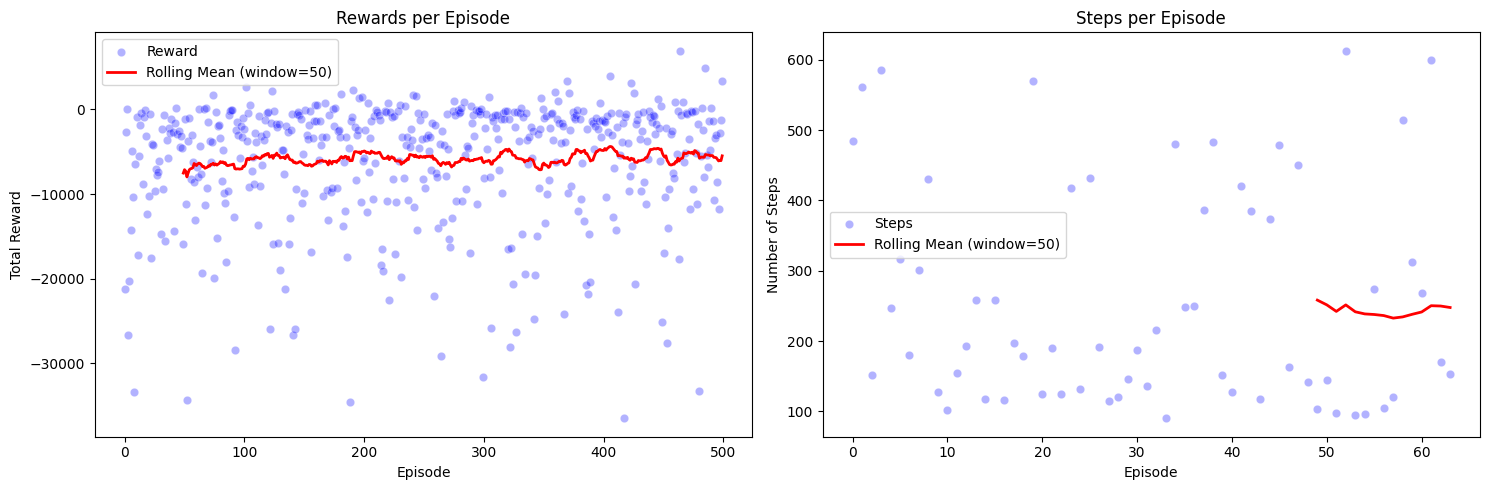

In [2]:
# Create the environment
env = CustomTrafficEnvironment(max_time_steps=10000, logging_enabled=False, seed=seed)

td_lambda = TemporalDifference(env, oiv = 0.1, alpha=2e-3, epsilon=1.0, lambd=0, gamma=0.8, epsilon_decay=0.9575, epsilon_min=0.05)
total_reward_list, total_steps_list = td_lambda.train(num_episodes = 500, on_policy = False, save_model = False)
total_rew = sum(total_reward_list)
avg_rew = np.mean(total_reward_list)
avg_steps = np.mean(total_steps_list)

print(f'Sum of total rewards = {total_rew}')
print(f'Average total reward per episode = {avg_rew}')
print(f'Average steps per episode = {avg_steps}')

# plot training metrics
td_lambda.plot_training_metrics(window_size=50)
plt.show()

### Analysis

In [3]:
print(len(td_lambda.Q))

1291


State Space Size = 5 x 5 x 5 (Clearance Rates) x 5 (Risk Factor) x 2 (Over Speed Limit) x 3 (Actions) = 3,750

In [11]:
5*5*5*5*2*3

3750

In [4]:
q_df = td_lambda.q_table_to_dataframe()
q_df.head()

,Current Lane Rate,Left Lane Rate,Right Lane Rate,Risk Factor,Over Speed Limit,Left,Stay,Right
0,4,0,4,0,0,0.191550,0.490647,9.575989
1,4,4,3,0,0,0.357501,9.261230,0.162707
2,3,0,3,0,0,0.025830,21.487622,0.339823
3,3,0,4,0,0,0.099331,-0.768282,5.907524
4,4,0,4,1,0,-0.008970,-0.912033,3.990305


In [5]:
lanes = ['Current', 'Left', 'Right']
for fast_lane in lanes:
    other_lanes = lanes.copy()
    other_lanes.remove(fast_lane)
    total = q_df.loc[((q_df[f'{fast_lane} Lane Rate'] > q_df[f'{other_lanes[0]} Lane Rate']) & (q_df[f'{fast_lane} Lane Rate'] > q_df[f'{other_lanes[1]} Lane Rate'])) & (q_df['Risk Factor'] < 5)].shape[0]
    rate = q_df.loc[((q_df[f'{fast_lane} Lane Rate'] > q_df[f'{other_lanes[0]} Lane Rate']) & (q_df[f'{fast_lane} Lane Rate'] > q_df[f'{other_lanes[1]} Lane Rate'])) & (q_df['Risk Factor'] < 5) \
    & ((q_df[f'{fast_lane if fast_lane != 'Current' else 'Stay'}'] > q_df[f'{other_lanes[0] if other_lanes[0] != 'Current' else 'Stay'}']) \
        & (q_df[f'{fast_lane if fast_lane != 'Current' else 'Stay'}'] > q_df[f'{other_lanes[1] if other_lanes[1] != 'Current' else 'Stay'}']))].shape[0]
    rate = rate/q_df.shape[0]
    print(f"Number of cases where the {fast_lane} lane is fastest and has the highest value for low risk: {rate*100}%")

Number of cases where the Current lane is fastest and has the highest value for low risk: 17.35089078233927%
Number of cases where the Left lane is fastest and has the highest value for low risk: 4.802478698683191%
Number of cases where the Right lane is fastest and has the highest value for low risk: 5.112316034082107%


### Evaluation

In [19]:
td_lambda.Env.enable_logging()

In [ ]:
# Evaluate the agent in inference mode
all_rewards, all_steps, log_file = td_lambda.evaluate(num_episodes=500)

# Print the results
print(f"Average cumulative rewards for TD-Lambda Agent: {round(np.mean(all_rewards))}")
print(f"Average timesteps to termination for TD-Lambda Agent: {round(np.mean(all_steps))}")

100%|██████████| 500/500 [00:18<00:00, 27.56it/s]

Early terminations: 423
Average cumulative rewards for TD-Lambda Agent: -5536
Average timesteps to termination for TD-Lambda Agent: 164


In [9]:
td_lambda.Env.disable_logging()

### Visualization

In [ ]:
json_path = log_file

extract_timesteps_from_json(json_path)

gif_filename = './gifs/task2/test_log_20241105_234146.gif'

create_visualization_from_cached_data(gif_filename=gif_filename, step_interval=1)

Timesteps data from the first line successfully cached, containing 273 timesteps
GIF saved at ./gifs/task2/test_log_20241105_234146.gif


### Hyperparameter Tuning

In [ ]:
hyperparameter_space = {
    'alpha': [1e-4, 1e-2],           # Learning rate range (log scale)
    'gamma': [0.1, 0.99],            # Discount factor range
    'epsilon_decay': [0.9, 0.9999],   # Epsilon decay range
    'epsilon_min': [0.01, 0.1],      # Minimum epsilon range
    'lambd': [0, 0.9]             # Lambda range for eligibility traces
}
env = CustomTrafficEnvironment(max_time_steps=10000, logging_enabled=False, seed=seed)
td_lambda = TemporalDifference(env)
# Run hyperparameter tuning
best_agent, best_params = td_lambda.hyperparameter_tuning(hyperparameter_space=hyperparameter_space, episodes=500, n_trials=30, on_policy=False)

[I 2024-11-05 01:53:08,568] A new study created in memory with name: no-name-6982d27d-ca3c-4d80-b920-b219700b9f93
100%|██████████| 500/500 [11:49<00:00,  1.42s/it]
[W 2024-11-05 02:04:58,385] Trial 0 failed with parameters: {'alpha': 0.0005604090760077114, 'gamma': 0.580588604955087, 'epsilon_decay': 0.9112669188092877, 'epsilon_min': 0.09757174374127979, 'lambd': 0.009376513888873728} because of the following error: ValueError('setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.').
Traceback (most recent call last):
  File "c:\Users\danie\OneDrive - Singapore Management University\SMU Singapore\Academics\Aug 2024\CS609_ReinforcementLearning\Project\LaneSwitchRL-Simulation\.venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "c:\Users\danie\OneDrive - Singapore Management University\S

Training statistics saved to ./logs/task2/training_logs.json
Truncated episodes: 410


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.